# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Построим модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Этапы проекта

1) Исследовательский анализ классов и набора фотографий

2) Создание модели и ее обучение

3) Выводы

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam

## Исследовательский анализ данных

Напишем функцию для загрузки данных о принадлежности фотографий к классам и проведем анализ этих данных

In [ ]:
def load_classes(path):
    #загрузка данных
    data = pd.read_csv(path + 'labels.csv')

    #отображение основной информации
    #display(data.head())
    #display(data.describe())
    print(data.info())
    print('Количество уникальных классов равно', len(data['real_age'].unique()))
    print('Количество повторяющихся строк', sum(data.duplicated()))

    #отображение распределения
    data['real_age'].hist(bins=100)
    plt.xlabel('Возраст')
    plt.ylabel('Частота встречаемости')
    plt.title('Распределение возраста людей на фотографиях')

    return data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None
Количество уникальных классов равно 97
Количество повторяющихся строк 0


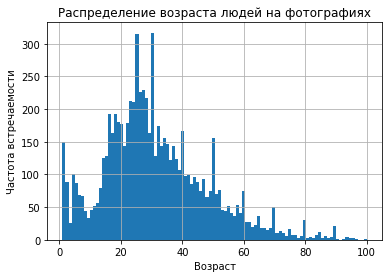

In [ ]:
classes = load_classes('/datasets/faces/')

Вывод:

Как видим, данные состоят из двух столбцов, включающих название фотографии и фозраст запечатленного человека в целочисленном формате. Всего данный файл содержит сведения о 7591 фотографии, при чем пропущенных или дублирующихся значений в таблице нет. Минимальное значение возраста - 1 год, максмальное - 100 лет, что соответствует реальон возможным значениям. Как видим, распределение данных можно приближенно считать нормальным, выбросов в данных нет. Количество уникальных классов равно 97.

Напишем функцию для загрузки фотографий

In [ ]:
def load_train(path):
    classes = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=(1/255),
                                 rotation_range=45,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,)

    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=classes,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

Выведем первые 15 фотографий и проведем их анализ

Found 5694 validated image filenames.


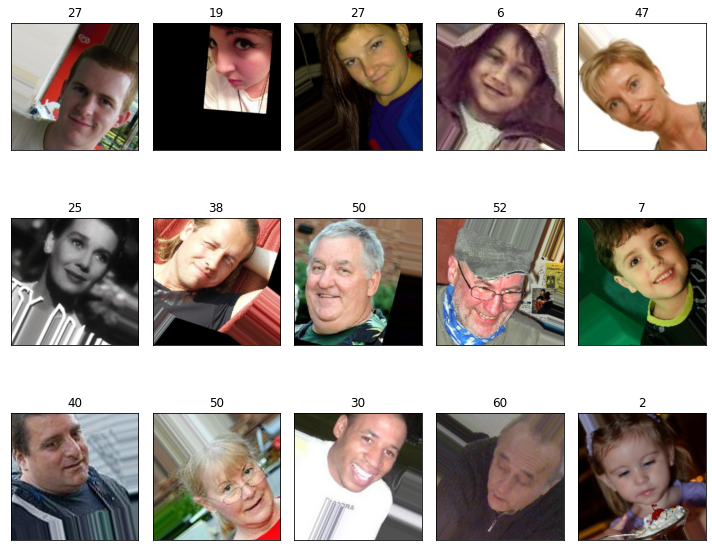

In [ ]:
features, target = load_train('/datasets/faces/').next()
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Вывод:

По фотографиям видим, что в данных встречаются как черно-белые, так и цветные фотографии. Помимо этого видим, что представлено в наборе данных всего 5694 фотографий. Можем заметить, то некоторе фотографии повернуты на некоторй угол или сдвинуты по одной из осей. Для улучшения качества модели в загрузке фотографий применим метод аугментации.

Над фотографиями указан возраст изображенного.

## Обучение модели

Для обуения модели напишем также еще одну функию load_test, загружающую тестовые данные.

За основу будущей модели возьмем предобуенную на большом наборе фотографий сверточную нейронную сеть ResNet50. При этом, в силу особенности нашей задаи удалим верхние слои предобученной нейронной сети, добавив взамен слой усреднения и 3 полносвязныых слоя. Последний слой имеет всего 1 нейрон, так как решаемаяя нами задачча - задача регрессии. Функция активации для всех слоев - ReLU. В качестве метрики и функции потерь взята характеристика MAE по условию задачи. Также, дляя увеличения точности подели применен оптимизатор Adam.

Тренировкаа модели выполнлась на протжении 10 эпох,для отслеживания результата промежутоныые результаты выислений выводились в консоль.

``` python
def load_train(path):
    classes = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=(1/255),
                                 rotation_range=45,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,)

    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=classes,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(180, 180),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_datagen_flow

def load_test(path):
    classes = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=(1/255))

    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=classes,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=(180, 180, 3),
                    weights='imagenet',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='relu'))

    opt = Adam(learning_rate=0.00005)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model
```

Приведем вывод при обуении модели

```
Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 80s - loss: 295.4760 - mae: 12.5789 - val_loss: 663.7352 - val_mae: 20.7998
Epoch 2/10
356/356 - 72s - loss: 116.8942 - mae: 8.2466 - val_loss: 258.5638 - val_mae: 11.7978
Epoch 3/10
356/356 - 72s - loss: 95.3136 - mae: 7.4408 - val_loss: 88.6770 - val_mae: 7.0587
Epoch 4/10
356/356 - 72s - loss: 79.4038 - mae: 6.8402 - val_loss: 84.2459 - val_mae: 6.8250
Epoch 5/10
356/356 - 73s - loss: 68.5140 - mae: 6.3704 - val_loss: 99.3239 - val_mae: 7.1719
Epoch 6/10
356/356 - 73s - loss: 59.5373 - mae: 5.9392 - val_loss: 86.1114 - val_mae: 6.7212
Epoch 7/10
356/356 - 72s - loss: 52.3333 - mae: 5.5750 - val_loss: 96.1170 - val_mae: 7.1318
Epoch 8/10
356/356 - 72s - loss: 47.3863 - mae: 5.3174 - val_loss: 84.6739 - val_mae: 6.8465
Epoch 9/10
356/356 - 73s - loss: 41.0947 - mae: 4.9349 - val_loss: 83.2774 - val_mae: 6.7499
Epoch 10/10
356/356 - 73s - loss: 37.6960 - mae: 4.7474 - val_loss: 84.5070 - val_mae: 6.9719


119/119 - 10s - loss: 84.5070 - mae: 6.9719
Test MAE: 6.9719
```

Вывод:

В ходе данного пункта нами была построена нейронная сеть и обучена на полученных данных. Наилучшее значение метрики на тестовой выборке - 6.9719.

## Анализ обученной модели

В результате построения и обучения модели нами была получена модель со следующими характеристиками:

- базовая архитектура модели - ResNet50
- верхнии слои заменены на слой усреднения и 3 полносвязных слоя с 64, 32 и 1 нейронами соответственно
- функция активации полносвязных слоев - ReLU
- алгоритм оптимизации - Adam с наальнм шагом - 0.00005
- метрика оценки качества модели и функция потерь - MAE

Для модели с описанными выше характеристиками удалось достичь наилучшего результата по метрике MAE = 6.9719.

Хотя данное значение и не велико, но с помощью данной модели будет тяжело оценивать добросовесность продавцов при продаже алкогольной и табачной продукции, так как слишком велика величина погрешности, почти 7 лет. Не смотря на это, даннаяя модель может подойти для ведения аналитических исследований по посещаемости магазинов различными возрастными категориями.